***Install the libraries and dependencies***

In [4]:
!pip install -q transformers
!pip install -q vaderSentiment

***Import modules***

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.optim import AdamW
import seaborn as sns
import matplotlib.pyplot as plt

**Load Data**

In [6]:
# Load your CSV files with columns 'Text' and 'Label'
columns = ['id', 'country', 'Label', 'Text']
train_csv_path = '/content/sample_data/twitter_training.csv'
test_csv_path = '/content/sample_data/twitter_validation.csv'

train_df = pd.read_csv(train_csv_path, names=columns)
test_df = pd.read_csv(test_csv_path, names=columns)


In [7]:
# Drop NaN values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
# Remove "irrelevant" entries
train_df = train_df[train_df['Label'] != 'Irrelevant']
test_df = test_df[test_df['Label'] != 'Irrelevant']

In [9]:
#count number of Label in the data
train_df['Label'].value_counts()

Positive    3187
Neutral     2589
Negative    2282
Name: Label, dtype: int64

In [10]:
#count number of Label in the data
test_df['Label'].value_counts()

Neutral     285
Positive    277
Negative    266
Name: Label, dtype: int64

**Label Mapping**

In [11]:
# Label mapping
Label_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}

# Apply Label mapping to convert string Labels to numerical values
train_df['Label'] = train_df['Label'].map(Label_mapping)
test_df['Label'] = test_df['Label'].map(Label_mapping)

In [12]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [13]:
print(train_df.head(10))

     id      country  Label                                               Text
0  2401  Borderlands      2  im getting on borderlands and i will murder yo...
1  2401  Borderlands      2  I am coming to the borders and I will kill you...
2  2401  Borderlands      2  im getting on borderlands and i will kill you ...
3  2401  Borderlands      2  im coming on borderlands and i will murder you...
4  2401  Borderlands      2  im getting on borderlands 2 and i will murder ...
5  2401  Borderlands      2  im getting into borderlands and i can murder y...
6  2402  Borderlands      2  So I spent a few hours making something for fu...
7  2402  Borderlands      2  So I spent a couple of hours doing something f...
8  2402  Borderlands      2  So I spent a few hours doing something for fun...
9  2402  Borderlands      2  So I spent a few hours making something for fu...


**VADER**

VADER Accuracy: 0.4819


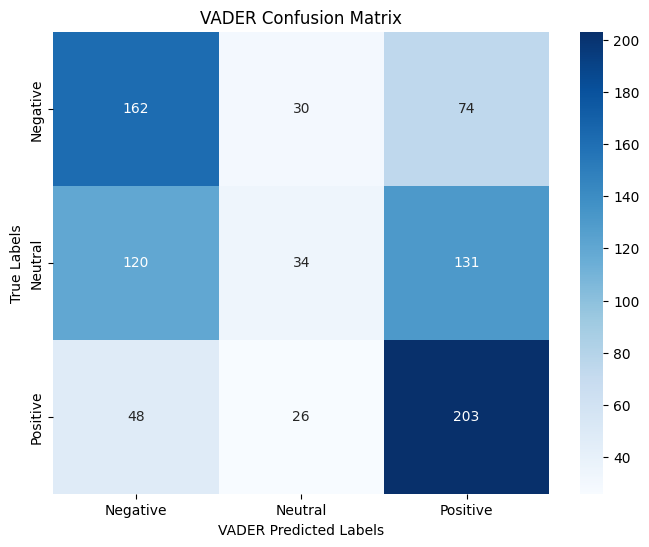

VADER Classification Report:
              precision    recall  f1-score   support

    Negative       0.49      0.61      0.54       266
     Neutral       0.38      0.12      0.18       285
    Positive       0.50      0.73      0.59       277

    accuracy                           0.48       828
   macro avg       0.46      0.49      0.44       828
weighted avg       0.45      0.48      0.44       828



In [14]:
#VADER Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

train_df['VADER_Score'] = train_df['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
test_df['VADER_Score'] = test_df['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Convert VADER scores to labels
threshold = 0.05
train_df['VADER_Label'] = np.where(train_df['VADER_Score'] > threshold, 2, np.where(train_df['VADER_Score'] < -threshold, 0, 1))
test_df['VADER_Label'] = np.where(test_df['VADER_Score'] > threshold, 2, np.where(test_df['VADER_Score'] < -threshold, 0, 1))

# Calculate VADER accuracy
vader_accuracy = accuracy_score(test_df['Label'], test_df['VADER_Label'])
print(f'VADER Accuracy: {vader_accuracy:.4f}')

# VADER Confusion Matrix
class_names = ['Negative', 'Neutral', 'Positive']
vader_conf_matrix = confusion_matrix(test_df['Label'], test_df['VADER_Label'])
plt.figure(figsize=(8, 6))
sns.heatmap(vader_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('VADER Predicted Labels')
plt.ylabel('True Labels')
plt.title('VADER Confusion Matrix')
plt.show()

# Classification Report for VADER
print('VADER Classification Report:')
print(classification_report(test_df['Label'], test_df['VADER_Label'], target_names=class_names))

**Define the Custom Dataset Class**

In [15]:
# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, Text, Label, tokenizer, max_length):
        self.Text = Text
        self.Label = Label
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.Text)

    def __getitem__(self, id):
        Text = str(self.Text[id])
        Label = int(self.Label[id])

        encoding = self.tokenizer(
            Text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'Label': torch.tensor(Label, dtype=torch.long)
        }

**Tokenizer and model initialization**

In [16]:
# Tokenizer and model initialization
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Prepare datasets**

In [17]:
# Prepare datasets
max_length = 128
train_dataset = SentimentDataset(train_df['Text'], train_df['Label'], tokenizer, max_length)
test_dataset = SentimentDataset(test_df['Text'], test_df['Label'], tokenizer, max_length)

In [18]:
# DataLoader initialization
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [19]:
# Model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # Use torch.optim.AdamW

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['Label'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

Epoch 3/3: 100%|██████████| 1008/1008 [3:12:52<00:00, 11.48s/it]


In [24]:
# Model evaluation
model.eval()
all_preds = []
all_Label = []
for batch in tqdm(test_dataloader, desc='Testing'):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    Label = batch['Label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    preds = torch.argmax(logits, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_Label.extend(Label.cpu().numpy())

# Calculate accuracy
roberta_accuracy = accuracy_score(all_Label, all_preds)
print(f'Accuracy: {roberta_accuracy:.4f}')



Testing: 100%|██████████| 104/104 [06:02<00:00,  3.49s/it]

Accuracy: 0.7548


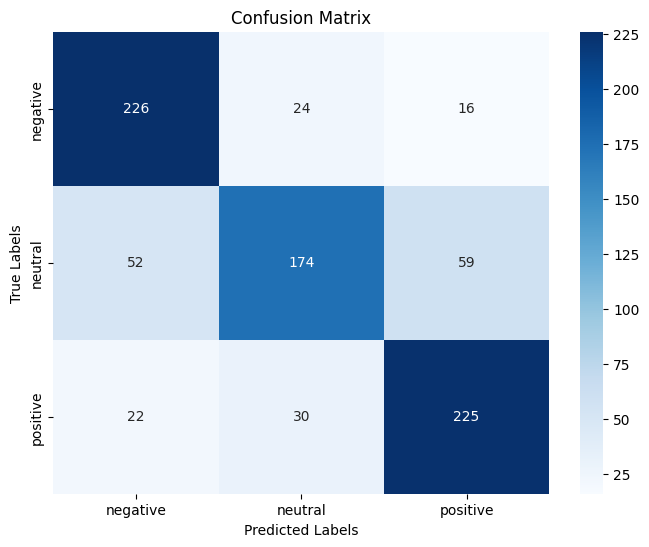

              precision    recall  f1-score   support

    negative       0.75      0.85      0.80       266
     neutral       0.76      0.61      0.68       285
    positive       0.75      0.81      0.78       277

    accuracy                           0.75       828
   macro avg       0.76      0.76      0.75       828
weighted avg       0.76      0.75      0.75       828



In [21]:
# Calculate confusion matrix
roberta_conf_matrix = confusion_matrix(all_Label, all_preds)

# Display confusion matrix
class_names = ['negative', 'neutral', 'positive']
plt.figure(figsize=(8, 6))
sns.heatmap(roberta_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_Label, all_preds, target_names=class_names))


**Display Accuracy and Confusion Matrix for VADER and DistilRoberta Model**

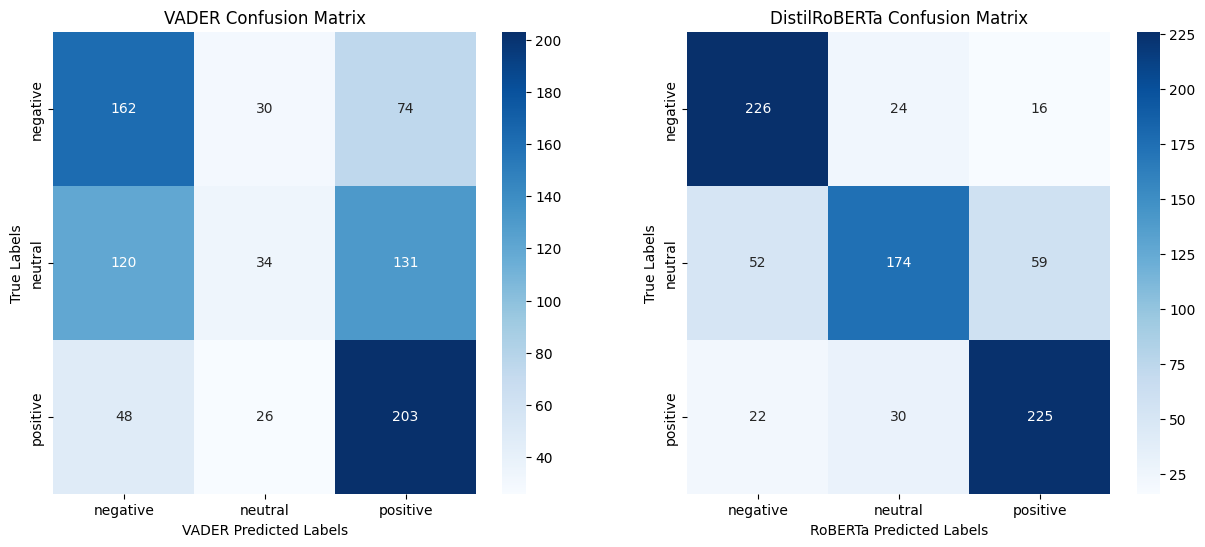

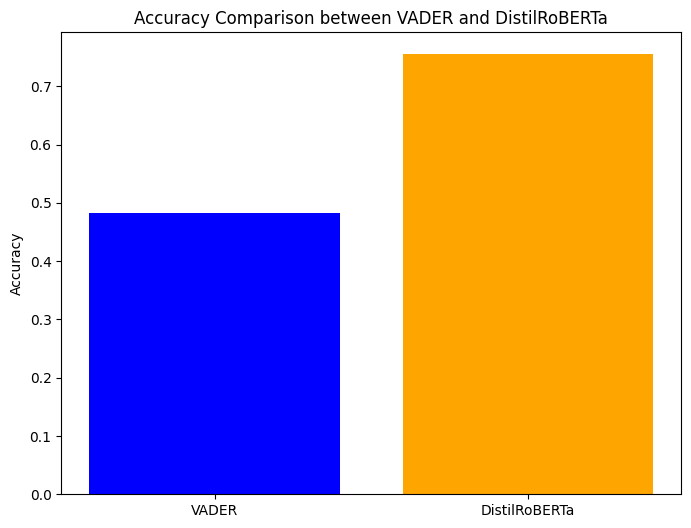

In [23]:
# Display both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# VADER Confusion Matrix
sns.heatmap(vader_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('VADER Confusion Matrix')
axes[0].set_xlabel('VADER Predicted Labels')
axes[0].set_ylabel('True Labels')

# RoBERTa Confusion Matrix
sns.heatmap(roberta_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('DistilRoBERTa Confusion Matrix')
axes[1].set_xlabel('RoBERTa Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

# Display accuracy comparison
fig, ax = plt.subplots(figsize=(8, 6))

models = ['VADER', 'DistilRoBERTa']
accuracies = [vader_accuracy, roberta_accuracy]

ax.bar(models, accuracies, color=['blue', 'orange'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison between VADER and DistilRoBERTa')

plt.show()